# Youtube Trend Tahmini Projesi

Bu projede kendimiz toplayıp oluşturduğumuz *`US_Videos_Dataset`* datasetini kullanarak bir videonun trend olup olamama ihtimalini veren bir model geliştirmek olacaktır. Bu dosyada ise birçok konuya değinilmiştir:
- Verinin analiz edilmesi (Data Analysis)
- Veriyi grafikler ile göreselleştirme (Data Visualisation)
- Veri temizleme uygulamaları (Data Cleaning)
- Özellik seçimi (Feature Engineering)
- Basit model oluşturma (Baseline Model)
- Youtube API ile veri çekme

### Gerekli Kütüphaneler

In [1]:
import os
import time
import random
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms.distance_measures import center
from scipy.ndimage import center_of_mass
from tqdm import tqdm
from datetime import datetime, timedelta

&nbsp;
### Dataseti Okuma

In [3]:
df = pd.read_csv("./Dataset/Final_Dataset.csv")

C:\Users\mahmi\AppData\Local\Temp\ipykernel_17216\2466515817.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./Dataset/Final_Dataset.csv")


&nbsp;
### Veri Seti hakkında özet bilgi

In [11]:
print("\nVeri Seti Boyutu (satır, sütun)")
print(df.shape)

print("\nSütun İsimleri")
for col in df.columns:
    print(f"- {col}")

print("\nSütunlardaki Eksik Değer Sayıları")
print(df.isnull().sum())

print("\nTemel Bilgi")
df.info()

print("\nSayısal Sütunlar - Temel İstatistikler")
display(df.describe())



Veri Seti Boyutu (satır, sütun)
(390043, 15)

Sütun İsimleri
- video_id
- title
- publishedAt
- channelId
- channelTitle
- categoryId
- trending_date
- tags
- view_count
- likes
- comment_count
- thumbnail_link
- comments_disabled
- description
- is_trending

Sütunlardaki Eksik Değer Sayıları
video_id                  0
title                     0
publishedAt               0
channelId                 0
channelTitle              0
categoryId                0
trending_date        218362
tags                 120820
view_count                0
likes                     0
comment_count             0
thumbnail_link            0
comments_disabled         0
description           59300
is_trending               0
dtype: int64

Temel Bilgi
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390043 entries, 0 to 390042
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   video_id           390043 non-null  object 
 

,categoryId,view_count,likes,comment_count,comments_disabled,is_trending
count,390043.000000,3.900430e+05,3.900430e+05,3.900430e+05,390043.000000,390043.000000
mean,20.426179,7.046562e+06,1.534973e+05,4.490697e+03,0.018662,0.440159
std,6.524139,4.896210e+07,6.717989e+05,4.198895e+04,0.135329,0.496407
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,19.000000,2.626010e+05,5.271000e+03,1.230000e+02,0.000000,0.000000
50%,22.000000,7.643870e+05,2.356100e+04,8.530000e+02,0.000000,0.000000
75%,24.000000,2.561359e+06,7.882900e+04,2.743000e+03,0.000000,1.000000
max,30.000000,4.168919e+09,4.337832e+07,1.048303e+07,1.000000,1.000000


#### Çıktıların Yorumlanması

Yukarıdaki çıktılarda gördüğümüz gibi bazı temel bilgiler bastırılmıştır.

Hemen dikkatimizi çekecek bazı veriler var. trending_date, tags ve description sütunlarında büyük miktarda eksik değer bulunmaktadır. Bunun olması gayet normal bir şeydir çünkü trend olmayan videoların hepsinin trend olma tarihi yoktur. Bu veriler modelde göz ardı edilebilir.

Aynı şekilde bütün videoların tags veya description kısmı olmak zorunda değil çünkü bazı içerik üreticileri bu alanları boş bırakırlar bu yüzden API dan dönen değer boş veya null olur.

Son olarak en sonda görmüş olduğumuz tabloda null olmayan video sayısı, Ortalama, Standart Sapma, Sütundaki Minimum değer ve medyan gibi değerler listelenmiştir.

&nbsp;
### Veri setinden Örnek çıktılar
Veri setinden trend olan ve olmayan veri örnekleri

In [12]:
print("\nTrending video örnekleri")
display(df[df["is_trending"] == 1].head(8))

print("\nNon Trending video örnekleri")
display(df[df["is_trending"] == 0].head(7))



Trending video örnekleri


,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,comment_count,thumbnail_link,comments_disabled,description,is_trending
0,G4M_621v1As,college farewell video#trending #viralshorts,2025-04-12T02:06:42Z,UC7k_7IF3s3TY-cowwxs_yWw,Vk_07_rider,22.0,2025-11-08,"college farewell video, DDU farewell video, fa...",125784084.0,1557178.0,1583.0,https://i.ytimg.com/vi/G4M_621v1As/default.jpg,0,DDU farewell party video \n college farewell v...,1
1,z2voqo_Jhx4,Busking in Manchester 🇬🇧 #blindfaith #guitar #...,2025-04-06T11:35:53Z,UCM_9JHB3xXPSzJfTkD86AtA,Leonardo Patrick,10.0,2025-11-08,NaN,94744011.0,925529.0,5849.0,https://i.ytimg.com/vi/z2voqo_Jhx4/default.jpg,0,NaN,1
2,jHIt9oHFLsw,This is what happens when you play Star Wars i...,2025-04-06T10:07:12Z,UC4YyKY5o60Kckk-GXOnhT2g,Violin Phonix,22.0,2025-11-08,NaN,61945818.0,1067412.0,4124.0,https://i.ytimg.com/vi/jHIt9oHFLsw/default.jpg,0,Full video : https://www.youtube.com/watch?v=Q...,1
3,gwRqLbWqKlM,LISA - FUTW (YouTube Music Nights Special Stag...,2025-03-19T03:29:33Z,UC6-BgjsBa5R3PZQ_kZ8hKPg,LLOUD Official,10.0,2025-11-08,"Blackpink, Lisa, Music, Fashion, K-Pop, kpop, ...",14555963.0,455816.0,20396.0,https://i.ytimg.com/vi/gwRqLbWqKlM/default.jpg,0,"LISA’s debut album, ‘Alter Ego’ is out now. Li...",1
4,prpRoyrutcE,Uljhi hai yeh kis jaal me tu…. Bengaluru ❤️,2025-04-14T10:17:58Z,UCiFXnvi8ESDukE25ol2foWQ,Mr.KiranJ,10.0,2025-11-08,NaN,26204942.0,336267.0,2333.0,https://i.ytimg.com/vi/prpRoyrutcE/default.jpg,0,NaN,1
5,drWvIuDxk1Q,"Mehak Khanzadi Bollywood Dance Performance, Di...",2025-04-13T17:44:34Z,UCjHpEOjYHeJWCS2exTjE-rg,SGStudio,24.0,2025-11-08,"Mehak Khanzadi Bollywood Dance Performance, Di...",14158396.0,18672.0,135.0,https://i.ytimg.com/vi/drWvIuDxk1Q/default.jpg,0,🔴 RECOMMENDED VIDEOS/PLAYLISTS\n✅https://youtu...,1
6,FPGV1gQrepU,Raanjhan Wins Best Playback Singer Female -Par...,2025-03-21T02:57:03Z,UCFVWHa07-3tFakZ4ScH8Chg,Sachet Parampara,10.0,2025-11-08,NaN,15692702.0,733264.0,2703.0,https://i.ytimg.com/vi/FPGV1gQrepU/default.jpg,0,NaN,1
7,P0hRd6A4Rdo,Ranking The Best School Singing Moments,2025-04-11T20:31:02Z,UC3de6IV6G1ZUhm3L1PyuhKA,Oqelex,22.0,2025-11-08,NaN,22654104.0,624402.0,2100.0,https://i.ytimg.com/vi/P0hRd6A4Rdo/default.jpg,0,Ranking The Best School Singing Moments,1



Non Trending video örnekleri


,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,comment_count,thumbnail_link,comments_disabled,description,is_trending
171681,GbvJP2pgAAI,Me vs Grandma Cooking Challenge Brainrot Battl...,2025-11-05T12:13:00Z,UCKZTeZmkmdhEldL1oBMu6LA,Multi DO Challenge,22.0,NaN,"challenge, challenges, prank, pranks, fun, fun...",25363.0,135.0,3.0,https://i.ytimg.com/vi/GbvJP2pgAAI/default.jpg,0,It's time for a new culinary battle! Start our...,0
171682,pCWTSUtpWaA,"Big, Medium and Small Plate Challenge | Crazy ...",2025-11-05T14:14:00Z,UCo90vVUjxpyL-zwAksnBKTA,Multi DO,22.0,NaN,"DIY, craft, crafts, prank, pranks, challenge, ...",4899.0,44.0,2.0,https://i.ytimg.com/vi/pCWTSUtpWaA/default.jpg,0,Are you ready for our new food challenge? It w...,0
171683,WtI9f7A4Iz4,Try Not to Laugh Challenge (IMPOSSIBLE) Laugh ...,2025-07-19T14:00:49Z,UC6iSAm2OgMS8e_RKuwnXzaw,Laugh Trapped,22.0,NaN,"laugh trapped, laugh trigger, funny video, vir...",5307806.0,67461.0,3754.0,https://i.ytimg.com/vi/WtI9f7A4Iz4/default.jpg,0,Don't forget to subscribe to LAUGH TRAPPED and...,0
171684,n2YcpAJJgVE,Ich vs Oma: Koch-Challenge | Verrückte Küchens...,2025-11-05T13:14:01Z,UCmMUP_m8M_NIGg5YanlEKog,Multi DO Challenge German,22.0,NaN,"multi do challenge, multido challenge, challen...",4170.0,31.0,0.0,https://i.ytimg.com/vi/n2YcpAJJgVE/default.jpg,0,Bist du bereit für unsere neue Food-Challenge?...,0
171685,vXUZpRRrIBU,Sour Family Sour Gummy Lemon Challenge! 🍋,2024-04-28T05:00:33Z,UCm4FUt0uVITowfThQhs0NNQ,The Faith Family,24.0,NaN,"sour king, sour king drew, sourking, sourkingdrew",156254668.0,2328908.0,8901.0,https://i.ytimg.com/vi/vXUZpRRrIBU/default.jpg,0,viral #gummy #challenge.,0
171686,q1EU0GgstIU,Rich vs Broke vs Giga Rich Food Challenge | Ta...,2025-11-03T14:13:01Z,UCo90vVUjxpyL-zwAksnBKTA,Multi DO,22.0,NaN,"DIY, craft, crafts, prank, pranks, challenge, ...",372578.0,1379.0,28.0,https://i.ytimg.com/vi/q1EU0GgstIU/default.jpg,0,Are you ready for a new culinary battle? Look ...,0
171687,sgGMb0FiKEc,300X PaniPuri With Chicken legs #eating Challe...,2025-10-16T04:09:51Z,UCIWH5MT_lGl9TkmtptZ5Dtw,Eat Sweet ASMR,22.0,NaN,"ASMR, Eatsweetasmr, Muckbang, Short, foodchall...",17920296.0,198501.0,295.0,https://i.ytimg.com/vi/sgGMb0FiKEc/default.jpg,0,300X PaniPuri With Chicken legs #eating Challe...,0


&nbsp;
### Data Visualisation (Veri Görselleştime)

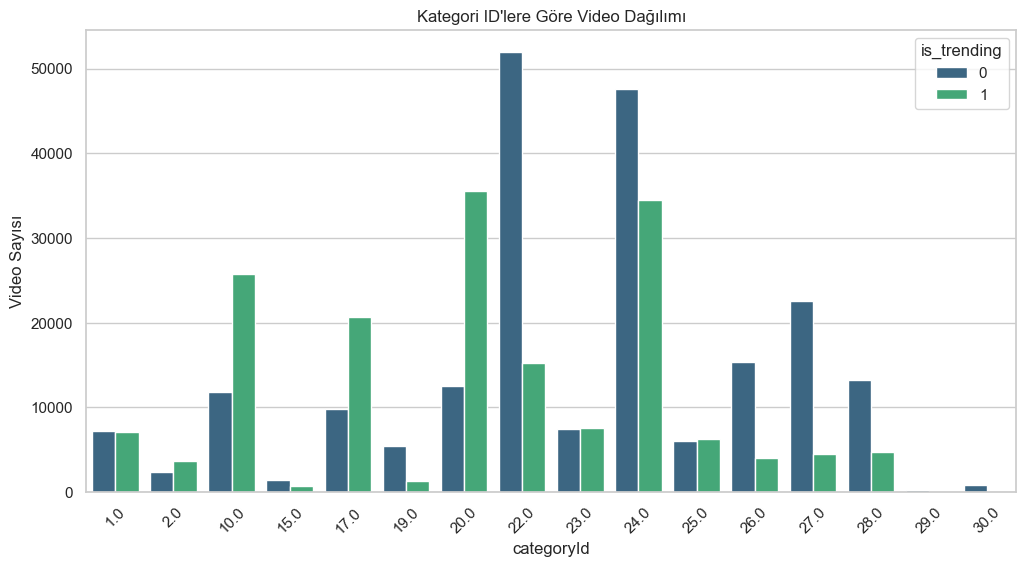

In [58]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="categoryId", palette="viridis", hue="is_trending")
plt.title("Kategori ID'lere Göre Video Dağılımı")
plt.xlabel("categoryId")
plt.ylabel("Video Sayısı")
plt.xticks(rotation=45)
plt.show()

Bu grafikte kategorilere ve video'nun trend olup olmama durumlarına bağlı olarak video miktarını görüntülüyoruz.

&nbsp;

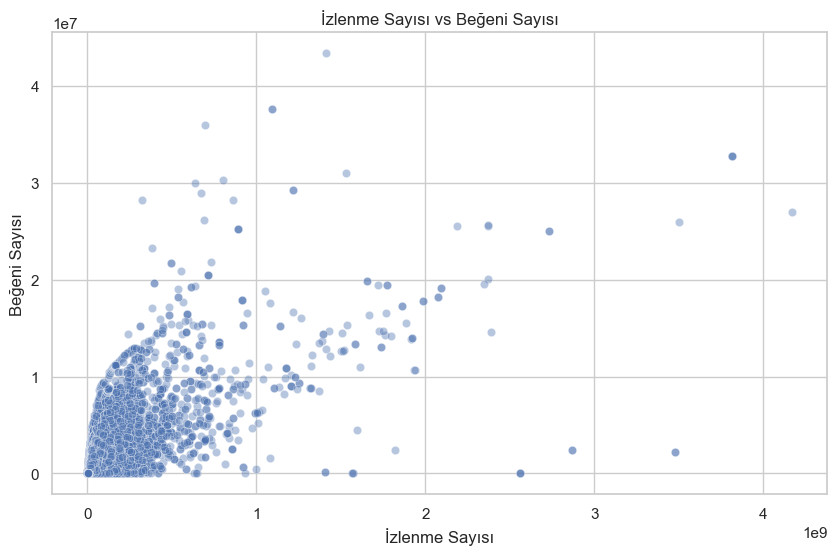


--- En yüksek likes değerine sahip video ---
Video ID: 8uiUz_IUkpo
İzlenme Sayısı: 1409166750.0
Beğeni Sayısı: 43378323.0
Yorum Sayısı: 52743.0
Video Linki: https://www.youtube.com/watch?v=8uiUz_IUkpo

--- En yüksek view_count değerine sahip video ---
Video ID: aU2KRF87RPc
İzlenme Sayısı: 4168918788.0
Beğeni Sayısı: 26977479.0
Yorum Sayısı: 0.0
Video Linki: https://www.youtube.com/watch?v=aU2KRF87RPc


In [59]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="view_count", y="likes", alpha=0.4)
plt.title("İzlenme Sayısı vs Beğeni Sayısı")
plt.xlabel("İzlenme Sayısı")
plt.ylabel("Beğeni Sayısı")
plt.show()

def get_max_video(column_name):
    row = df.loc[df[column_name].idxmax()]

    print(f"\n--- En yüksek {column_name} değerine sahip video ---")
    print("Video ID:", row["video_id"])
    print("İzlenme Sayısı:", row["view_count"])
    print("Beğeni Sayısı:", row["likes"])
    print("Yorum Sayısı:", row["comment_count"])

    link = f"https://www.youtube.com/watch?v={row['video_id']}"
    print("Video Linki:", link)

    return None

get_max_video("likes")
get_max_video("view_count")


Yukarıdaki grafik ve çıktılarda videoların beğeni ve izlenme sayısılarına göre scatterplot yardımıyla görüntüledik. Bu grafikte görüyoruz ki bazı videolar aşırı büyük değerlere sahiptir. Bunun gibi verilere outlier(Uç) veriler denir.

Bu tür veriler modeli olumsuz bir şekilde etkiler çünkü modelin doğru bir şekilde tahmin yapmasına engel olur ve yanlış bir şekilde öğrenmesini sağlar.

Bu yüzden bunun gibi verilerin ya temizlenmesi gerekir yada uygun modeli seçerek göz ardı edilmesi gerekir. Başka bir geçerli yöntem olarak verileri normalize edip çok aşırı değer farklılıkların daraltmak.

&nbsp;

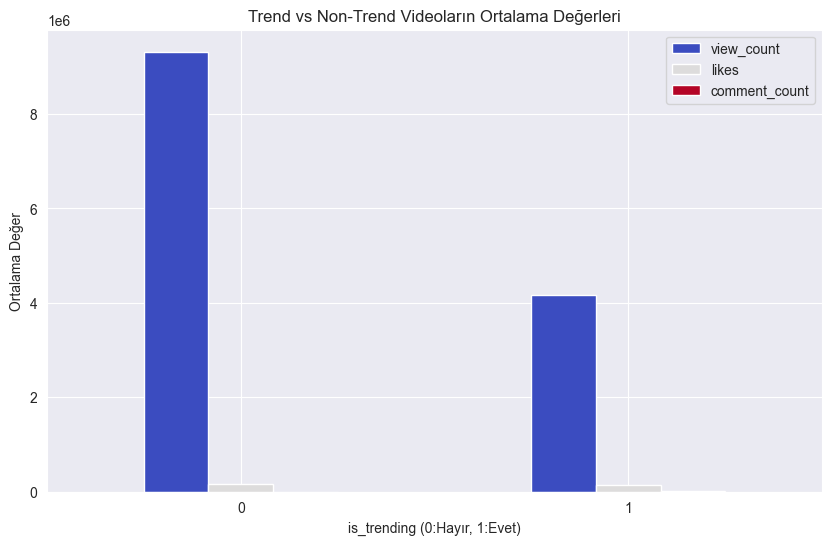

In [49]:
trend_group = df.groupby("is_trending")[["view_count", "likes", "comment_count"]].mean()

trend_group.plot(kind="bar", figsize=(10,6), colormap="coolwarm")
plt.title("Trend vs Non-Trend Videoların Ortalama Değerleri")
plt.xlabel("is_trending (0:Hayır, 1:Evet)")
plt.ylabel("Ortalama Değer")
plt.xticks(rotation=0)
plt.show()
print("\n\n")

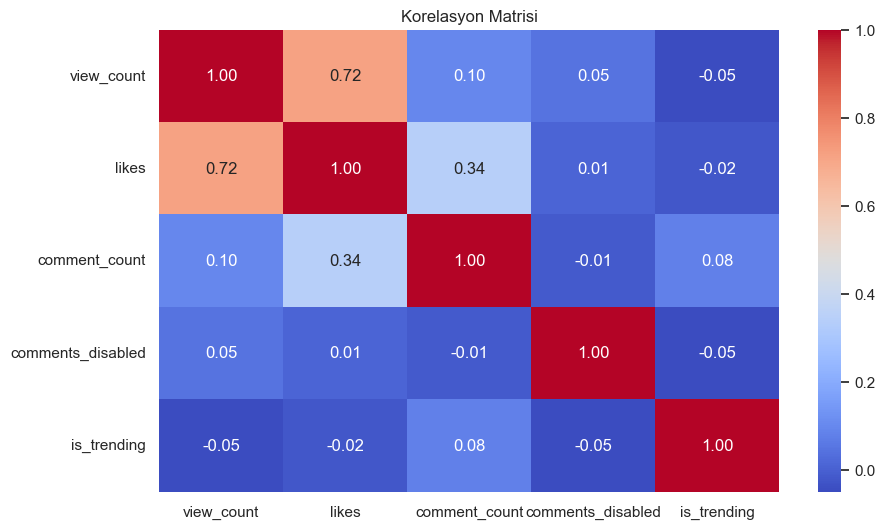

In [62]:
plt.figure(figsize=(10,6))
sns.heatmap(df[["view_count","likes","comment_count","comments_disabled","is_trending"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasyon Matrisi")
plt.show()

**Correlation Matrix(Korelasyon Matrisi):** Veri setindeki sayısal sütunların birbirleri ile ilişki güçlülüğünü görselleştirir.
Pozitif Değer: Güçlü ilişki. Biri artarken diğeri de artıyor.
0'a yakın değer: Neredeyse ilişki yok.
Negatif Değer: Negatif güçlü ilişki. Biri artarken diğer azalıyor.

&nbsp;

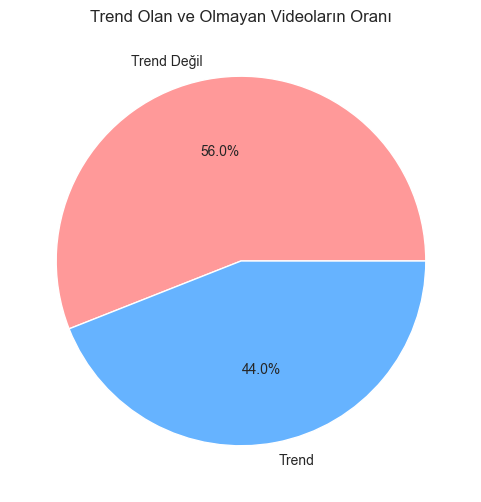

In [51]:
plt.figure(figsize=(6,6))
df["is_trending"].value_counts().plot(kind="pie", autopct="%1.1f%%", labels=["Trend Değil","Trend"], colors=["#ff9999","#66b3ff"])
plt.title("Trend Olan ve Olmayan Videoların Oranı")
plt.ylabel("")
plt.show()
print("\n\n")

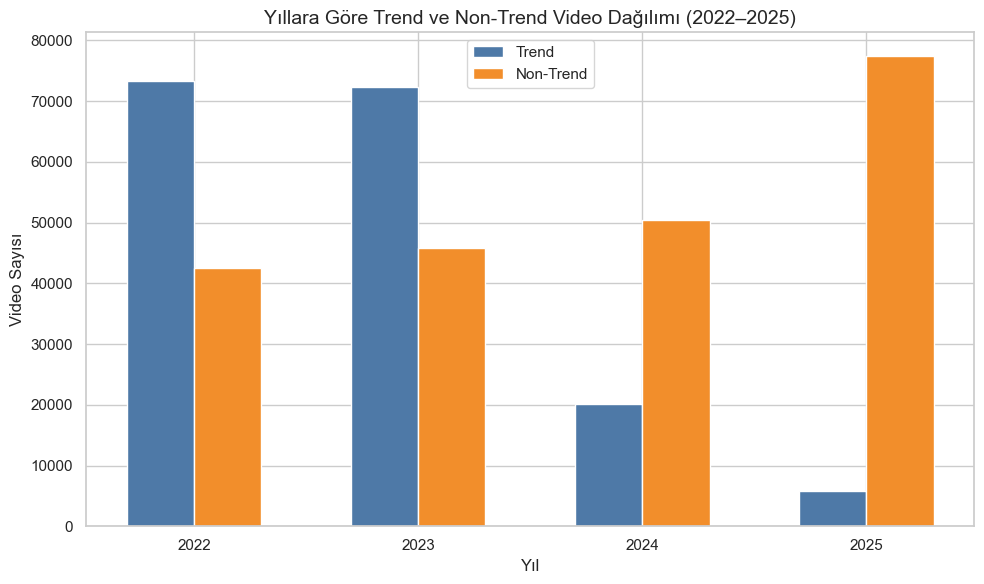

In [57]:
df["publishedAt"] = pd.to_datetime(df["publishedAt"], errors="coerce")
df["year"] = df["publishedAt"].dt.year

df = df[(df["year"] >= 2022) & (df["year"] <= 2025)]

trend_df = df[df["is_trending"] == 1]
nontrend_df = df[df["is_trending"] == 0]

trend_by_year = trend_df["year"].value_counts().sort_index()
nontrend_by_year = nontrend_df["year"].value_counts().sort_index()

sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
plt.bar(trend_by_year.index - 0.15, trend_by_year.values,
        width=0.3, label="Trend", color="#4e79a7")
plt.bar(nontrend_by_year.index + 0.15, nontrend_by_year.values,
        width=0.3, label="Non-Trend", color="#f28e2b")

plt.title("Yıllara Göre Trend ve Non-Trend Video Dağılımı (2022–2025)", fontsize=14)
plt.xlabel("Yıl")
plt.ylabel("Video Sayısı")
plt.xticks(trend_by_year.index)

plt.legend()
plt.tight_layout()
plt.show()

#### Sonuçların Değerlendirilmesi
Veri setimizdeki değerleri cansız ve renksiz bir `string`'ten canlı, interaktif ve anlaşılabilirliği yüksek birer grafikle görselleştirdik. Bu bize veri ile nasıl davranmamız ve nelere dikkat etmemizin gerektiğini çok güzel bir şekilde anlamamıza yardımcı oldu.